# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.8.0


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


2022-02-25 16:34:48.937015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train model

In [6]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2182 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.1161 - val_sparse_categorical_accuracy: 0.9625
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0734 - val_sparse_categorical_accuracy: 0.9764
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.0619 - val_sparse_categorical_accuracy: 0.9801
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0740 - val_sparse_categorical_accuracy: 0.9786
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0442 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.0678 - val_sparse_categorical_accuracy: 0.9803


In [7]:
test_img = test_images[:1]
model.predict(test_img)

array([[ -8.602178 ,  -7.0175657,  -2.974425 ,  -1.3765854, -13.144325 ,
         -6.0577726, -21.487701 ,  10.945064 ,  -5.2026153,   0.9502902]],
      dtype=float32)

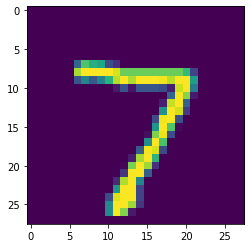

In [8]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [9]:
!rm -rf mnist_model

In [10]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


2022-02-25 16:35:26.593315: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Inspect saved model

In [11]:
!tree mnist_model

mnist_model
├── assets
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 4 files


In [12]:
!saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: serving_default_dense_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


### Load model

In [13]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


### Predict

In [14]:
new_model.predict(test_images[:1])

array([[ -8.602178 ,  -7.0175657,  -2.974425 ,  -1.3765854, -13.144325 ,
         -6.0577726, -21.487701 ,  10.945064 ,  -5.2026153,   0.9502902]],
      dtype=float32)

## PySpark

In [15]:
import pandas as pd

# from pyspark.sql.functions import col, pandas_udf, PandasUDFType
# from pyspark.sql.types import *

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [16]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(10000, 784)

In [17]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf)

CPU times: user 51.1 s, sys: 35.8 ms, total: 51.1 s
Wall time: 53.3 s


In [18]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 255 ms, sys: 0 ns, total: 255 ms
Wall time: 252 ms


(10000, 1)

In [19]:
%%time
df = spark.createDataFrame(pdf)

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 369 ms


### Save the test dataset as parquet files

In [20]:
df.write.mode("overwrite").parquet("mnist_test")

22/02/25 16:36:23 WARN TaskSetManager: Stage 0 contains a task of very large size (7067 KiB). The maximum recommended task size is 1000 KiB.


### Check arrow memory configuration

In [21]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "512")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

22/02/25 16:36:27 WARN TaskSetManager: Stage 1 contains a task of very large size (7067 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import sparkext

In [23]:
df = spark.read.parquet("mnist_test")

In [24]:
model = sparkext.tensorflow.Model("/home/leey/dev/sparkext/examples/tensorflow/mnist_model")

Loading model on driver from /home/leey/dev/sparkext/examples/tensorflow/mnist_model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [25]:
predictions = model.transform(df)

/home/leey/devpub/spark/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


INFO:tensorflow:Assets written to: ram://ca4e2241-5d24-4cfc-b4c5-28939e60c557/assets


In [26]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

### Check predictions

In [27]:
predictions.take(1)

[Row(prediction=[-11.096097946166992, -11.572307586669922, -7.276870250701904, -1.8528655767440796, -10.026632308959961, 9.345190048217773, -4.494255065917969, -13.201090812683105, -2.285233736038208, 4.933923244476318])]

In [28]:
img = df.take(1)[0].data
img = np.array(img).reshape(28,28)

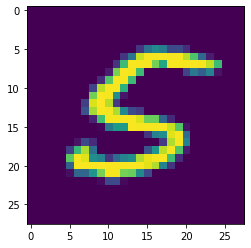

In [29]:
plt.figure()
plt.imshow(img)
plt.show()